## Guidance Modes
In this demo, you will learn how to use the guidance computer demonstrated in the previous tutorial to dynamically change the pointing mode of the spacecraft. This demo involves:
1. Extending the simulation case created within the Quick Start Demo to change the pointing mode associated with the guidance computer.
2. Sequential propagation of the spacecraft and orbit state.
3. Plot the error in attitude between the actual and target attitude defined as Modified Rodrigues Paramaters.

In [9]:
# zendir imports
from zendir import Credentials, Simulation, System, Object
from zendir.maths import astro
# other imports
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Authenticate your zendir access


In [ ]:
# Construct the credentials
credentials = Credentials(access="API ACCESS KEY")

simulation: Simulation = Simulation.get(credentials)

### Setup the spacecraft and components
The following cells configure the spacecraft and its components. For more details, please refer to the Quick Start demo.

In [11]:
# universe configuration parameters
epoch = datetime(2023, 1, 1)

# get the universe associated with our simulation, setting it with a desired epoch
universe: System = simulation.get_system(
    "SolarSystem",
    Epoch=epoch
)

In [12]:
# satellite configuration parameters
mass = 750  # kg
center_of_mass = np.array([0.0, 0.0, 0.0])  # m
moment_of_inertia = np.diag([900, 800, 600])  # kg m^2

semi_major_axis = 7000e3  # m
eccentricity = 0.001
inclination = 97.5  # deg
raan = 5  # deg
arg_perigee = 10  # deg
true_anomaly = 20  # deg

# initial attitude and rate, defined in modified rodriquez parameters
attitude = np.array([0.1, 0.2, -0.3])
attitude_rate = np.array([0.001, -0.01, 0.03])

In [13]:
# convert the classical orbital elements to state vectors, using zendir's utility functions, to help initialise the orbit
orbit: tuple = astro.classical_to_vector_elements_deg(
    semi_major_axis=semi_major_axis,
    eccentricity=eccentricity,
    inclination=inclination,
    right_ascension=raan,
    argument_of_periapsis=arg_perigee,
    true_anomaly=true_anomaly,
)

# add the satellite object to the simulation
# zendir can either hard-set the mass, center of mass, and moment of inertia properties of the spacecraft; or calculate them based on attached components. In this simple case, we will hard-set the by setting the OverrideMass property to True.
spacecraft: Object = simulation.add_object(
    "Spacecraft",
    TotalMass=mass,
    TotalCenterOfMassB_B=center_of_mass,  # com of mass of the spacecraft in the body frame
    TotalMomentOfInertiaB_B=moment_of_inertia,  # moment of inertia of the spacecraft in the body frame
    OverrideMass=True,
    Position=orbit[0],
    Velocity=orbit[1],
    Attitude=attitude,
    AttitudeRate=attitude_rate,
)

In [14]:
# Adds a reaction wheel array as a child component of the spacecraft. The reaction wheel array makes tracking data for individual reaction wheels much easier.
reaction_wheels: Object = spacecraft.add_child("ReactionWheelArray")

# Adds individual reaction wheels to the reaction wheel array using the same add_child method. The reaction wheels are initialised within default properties such as max wheel speed, max torque, etc... These properties can be overridden by setting the desired properties in the add_child method. In this case, we set the wheel spin axes to be aligned with the body frame axes.
rw1: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([1, 0, 0])
)
rw2: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 1, 0])
)
rw3: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 0, 1])
)

# Adds a guidance computer which will automatically link to the reaction wheels. The guidance computer contains attitude control algorithms and can be used to conveniently set to different pointing modes.
computer: Object = spacecraft.add_child("GuidanceComputer")

# Assign the message to the computer
computer.set(
    PointingMode="Nadir",
    ControllerMode="MRP",
    MappingMode="ReactionWheels",
)

In [15]:
# subscribe to the data
# set the interval (in seconds) at which data is polled.
simulation.set_tracking_interval(interval=30)

# each object, system, and simulation contain data messages that can be subscribed to. Messages associated with each object can be found in the zendir documentation.
simulation.track_object(computer.get_message("Out_AttitudeErrorMsg"))
simulation.track_object(spacecraft.get_message("Out_SpacecraftStateMsg"))
simulation.track_object(computer.get_message("Out_GuidanceChainMsg"))

In [16]:
duration = 864  # sec
time_step = 0.1  # sec
simulation.tick_duration(step=time_step, time=duration)

---
## 1. Changing the Pointing Mode
Any property of a component can be updated by using the .set(PropertyName=PropertyValue) method from the object itself. In this case, we use this method to set the value of the PointingMode property of the GuidanceComputer. For more information on what properties are available for a given component, please refer to the API Reference guide at www.nominalsys.com

In [17]:
computer.set(PointingMode="Sun")

---
## 2. Sequential Propagation
Simulations can propagated forward in time in steps by calling tick_duration again. This will propagate the state of the spacecraft from that resulting from the most previous propagation, except where changes have been made to the simulation configuration. In this case, the simulation will propagate the state of the spacecraft and its orbit from the final state from the previous .tick_duration call, except now the PointingMode has been updated to Sun pointing.

In [18]:
simulation.tick_duration(step=time_step, time=duration)

In [19]:
computer.set(PointingMode="Velocity")
simulation.tick_duration(step=time_step, time=duration)

In [20]:
computer.set(PointingMode="Inertial")
simulation.tick_duration(step=time_step, time=duration)

---
## 3. Plot the Attitude Error
The plots below show the instantaneous change in desired pointing modes, as well as the response of the attitude determination and control system.

Data queried will span all data generated for all "tick_duration" calls

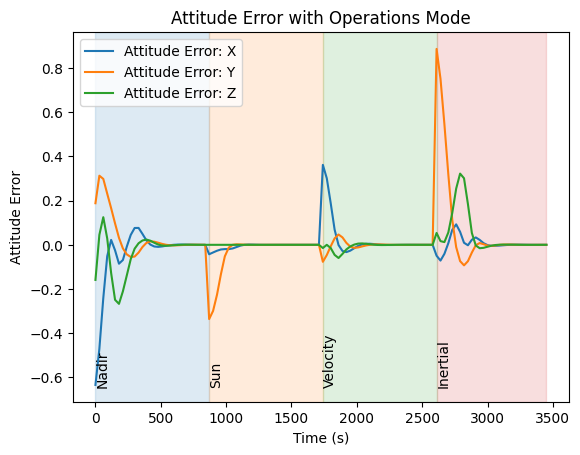

In [21]:
df_att_error = simulation.query_dataframe(computer.get_message("Out_AttitudeErrorMsg"))
df_ops_modes = simulation.query_dataframe(computer.get_message("Out_GuidanceChainMsg"))

# get the rows where the mode changes
df_ops_modes_diff = df_ops_modes[df_ops_modes["PointingMode"] != df_ops_modes["PointingMode"].shift(1)]

fig, ax = plt.subplots()
ax.plot(df_att_error.loc[:, "Time"], df_att_error.loc[:, "Sigma_BR_0"], label="Attitude Error: X")
ax.plot(df_att_error.loc[:, "Time"], df_att_error.loc[:, "Sigma_BR_1"], label="Attitude Error: Y")
ax.plot(df_att_error.loc[:, "Time"], df_att_error.loc[:, "Sigma_BR_2"], label="Attitude Error: Z")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Attitude Error")
ax.set_title("Attitude Error with Operations Mode")
ax.legend()

# add the background shading for the operations mode
for i in range(0, len(df_ops_modes_diff)):
    if i == len(df_ops_modes_diff) - 1:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes.loc[:, "Time"].iloc[-1]
    else:
        x = df_ops_modes_diff.loc[:, "Time"].iloc[i]
        y = df_ops_modes_diff.loc[:, "Time"].iloc[i+1]
        
    ax.axvspan(x, y, color=f"C{i}", alpha=0.15)
    # annotate the mode, placing the text at the left edge of the shaded region
    min_x = np.min(df_att_error.loc[:, "Sigma_BR_0"])
    ax.text(df_ops_modes_diff.loc[:, "Time"].iloc[i], min_x, df_ops_modes_diff.loc[:, "PointingMode"].iloc[i], rotation=90)

plt.show()